# Analysis of Classified Tweets and Identified Topics

## Step 1: Import Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import nltk
import string
from gensim import corpora, models
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from gensim.utils import effective_n_jobs
import nltk
from nltk.stem.snowball import SnowballStemmer
import util

In [2]:
%load_ext autoreload
%autoreload 2

## Step 2: Data Cleaning and Wrangling

Import data containing politicians' biographies, ideology scores, leadership scores and twitter handles retrieved from congress.gov, senate.gov, GovTrack USA and Twitter. Clean and merge data into a single dataframe

In [56]:
#Senators Bio
senate = util.main_cleaner("senate_women")
#Congress Bio
congress = util.main_cleaner("congress_women", congress=True)
#Senate Ideology Scores
senate_ideology = util.cleaner("senate_ideology", "ideology")
#Senate Leadership Scores
senate_leadership = util.cleaner("senate_leadership", "leadership")

#merge
senate_women = util.data_merge(senate,
                               senate_ideology,
                               senate_leadership,
                               ["Last Name",
                                "state"])
senate_women = senate_women.fillna({"district": 0})

#congress ideology scores
congress_ideology = util.cleaner("congress_ideology", "ideology")
#congress leadership scores
congress_leadership = util.cleaner("congress_leadership", "leadership")

#merge
congress_women = util.data_merge(congress,
                                 congress_ideology,
                                 congress_leadership,
                                 ["Last Name",
                                  "state",
                                  "district"])

#load dataset twitter_handles.csv with the twitter accounts of all women in us office
twitter_handles = pd.read_csv("twitter_handles.csv")
twitter_handles = twitter_handles.rename(columns={"Name": "Full Name"})
twitter_handles = twitter_handles[["Full Name", "Link", "User_name"]]

#merge all our datasets together
women_in_office = pd.concat([senate_women, congress_women])
women_in_office["Middle Name"].fillna("", inplace=True)
women_in_office["Full Name"] = women_in_office["First Name"] + " " + women_in_office["Middle Name"] + " " + women_in_office["Last Name"]
women_in_office["Full Name"] = women_in_office["Full Name"].str.replace("  ", " ")
women_in_office = pd.merge(women_in_office, twitter_handles, on="Full Name")

In [4]:
#Check length to make sure we did not lose any senators, 146 is the correct number (122 congress + 24 senate)
len(women_in_office)

146

## Step 3: Examine Tweets with Misogynistic Content

We have already classified all our tweets with our classifier. Our results were surprising, only several hundred tweets from our dataset of over 400, 000 tweets contained miogynistic content, according to our model. We can plot a wordcloud to get a better sense of what these misogynistic words are.

In [5]:
#Load data
tweets = pd.read_csv("./prediction_cs122.csv")
tweets = tweets[["candidate_user_name",
                 "tweet",
                 "pol_party",
                 "Predicted"]]

In [6]:
#subset tweets classified as containing misogynistic contents
tweets_mis = tweets[tweets['Predicted'] == 0].groupby(['candidate_user_name', "pol_party"])["tweet"].agg(''.join)

In [67]:
tweets_mis = tweets_mis.to_frame().reset_index()

Text(0, 0.5, 'Number of Politicians')

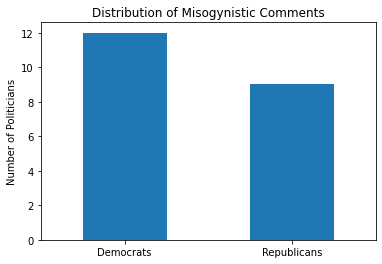

In [87]:
ax = tweets_mis["pol_party"].value_counts().plot(kind='bar', rot=0)
ax.set_xticklabels(["Democrats", "Republicans"])
plt.title("Distribution of Misogynistic Comments")
plt.ylabel("Number of Politicians")

Misogynistic tweets were only found in 21 twitter accounts belonging to 12 democrats and 9 republicans

In [90]:
for i in tweets_mis["candidate_user_name"]:
    print(i)

AOC
IlhanMN
MarshaBlackburn
NancyMace
RepJayapal
SenCapito
SenDuckworth
SenFeinstein
SenJoniErnst
SenTinaSmith
SenatorCollins
SpeakerPelosi
cathymcmorris
ilhan
laurenboebert
lisamurkowski
maziehirono
repaoc
repstefanik
senwarren
virginiafoxx


These are the usernames of the identified accounts.

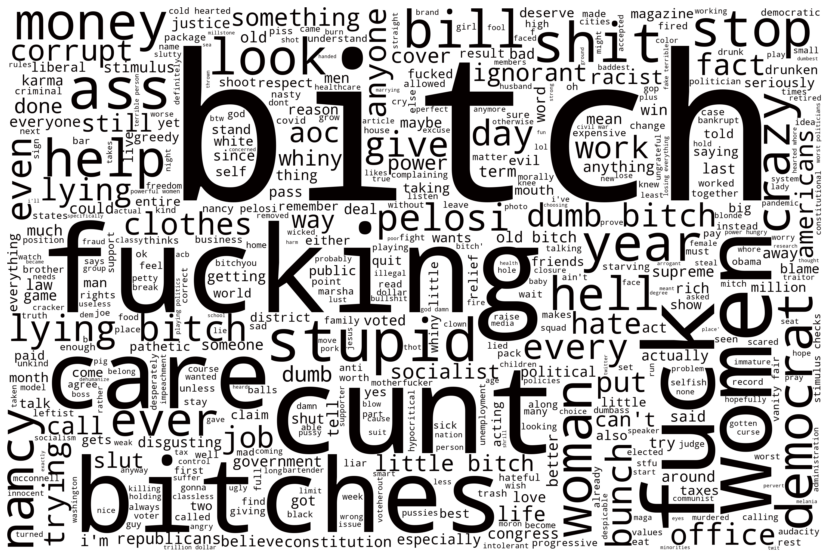

In [7]:
util.generate_wordcloud(tweets_mis)

As we can see, misogyny primarily comes in the form of profanity and direct insults. Additionally, we can also see that politicians like Nancy Pelosi and Alexandria Ocasio-Cortez are often singled out for abuse.

## Step 4: Examine Tweets without Misogynistic Content

But what about the majority of our tweets that do not contain misogynistic content? Here, we use topic modelling to determine if there are other topics that are coming through which can potentially contain implicit forms of misogyny not captured by our classifier.

In [8]:
#Load topic model
ldamodel = models.ldamodel.LdaModel.load('ldamodel12')

In [34]:
#Explore Topics
for i, topic in ldamodel.show_topics(formatted=False, num_words=100, num_topics=12):
    print('Topic {}: \n{}'.format(i, [w[0] for w in topic]))

Topic 0: 
['recognizeartsakh', 'azerbaijan', 'artsakh', 'turkey', 'lindsey', 'decided', 'nh', 'presidential', 'hug', 'voters', 'may', 'cosponsoring', 'sanctionazerbaijan', 'turkish', 'oh', 'first', 'passing', 'genocidal', 'sanctionturkey', 'waged', 'isis', 'officially', 'states', 'allies', 'response', 'resign', 'warcrimes', 'dear', 'bombed', 'hospital', 'children', 'chinese', 'campaign', 'rights', 'barrett', 'feinstein', 'pass', 'ca', 'hearing', 'spy', 'hearings', 'support', 'california', 'voted', 'stop', 'hugged', 'arms', 'human', 'armenia', 'sales', 'fyi', 'armenians', 'justice', 'late', 'committee', 'process', 'dianne', 'judiciary', 'cosponsor', 'abuses', 'peaceforarmenians', 'hugging', 'regarding', 'thank', 'recognize', 'independence', 'independent', 'committed', 'step', 'upon', 'senfeinstein', 'diane', 'republic', 'help', 'leadership', 'urgent', 'confirmation', 'necessary', 'amy', 'munitions', 'judge', 'driver', 'lindsay', 'china', 'war', 'acb', 'law', 'jurist', 'old', 'capolitics

From our lda model we can identify several topics:
 - Topic 0 and 3 reference foreign policy issues such as the conflict between armenia and azerbaijan
 - Topics 1, 2, 4 and 7 indicate some degree of support for women from the democratic party running for office, with mentions of gratitutde for the covid stimulus package passed by the majority democrat house and senate.
 - Topic 6 is not coherent and would require further cleaning to be intelligible.
 - Topics 5 and 8 seems to be critical of women from the democratic party with mentions of covid restrictions, excessive government spending and perceived radicalism within the party.
 - Topic 9 has a mix of support and criticism of republican women running for congress. There is support for candidates like laura loomer who is affiliated with the populist faction of the republican party and ridicule for mainstream conservatives like Joni Ernst.
 - Topic 10 appears to show support for republican women running for office, with congresswoman jamie buetler being explicitly mentioned.
 - Topic 11 centers around immigration issues with words indicating the presence of xenophobia against non-white immigrant politicians such as Ilhan Omar 

In [25]:
#subset data
tweets_nonmis = tweets[tweets['Predicted'] == 1].groupby(['candidate_user_name', "pol_party"]).agg(''.join)
tweets_nonmis.reset_index(inplace = True)

#Now we can recreate our corpus and dictionary for these models
tweets_nonmis['tokens'] = util.tokenize_tweets(tweets_nonmis['tweet'])
dictionary, bow_corpus = util.prepare_data(tweets_nonmis['tokens'])

C:\Users\thiya\AppData\Local\Temp\ipykernel_16372\2208092557.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  tweets_nonmis = tweets[tweets['Predicted'] == 1].groupby(['candidate_user_name', "pol_party"]).agg(''.join)


Now, we weight each politician's tweets by topics to get a sense of topic distributions in tweets mentioning that particular politician

In [26]:
tweets_nonmis = tweets_nonmis.apply(util.fill_topic_weights,
                          axis=1, args=[bow_corpus, ldamodel]).fillna(0)

,0,1,10,11,2,3,4,5,6,7,8,9,candidate_user_name,pol_party,tokens,tweet
0,0.000000,0.000000,0.000000,0.046425,0.000000,0.014058,0.111021,0.809423,0.000000,0.000000,0.000000,0.014064,AOC,Democrat,"[oops, sorry, trying, send, collins, love, out...","O Oops, sorry. I was trying to send that to Co..."
1,0.000000,0.000000,0.000000,0.093339,0.000000,0.053359,0.148257,0.685106,0.000000,0.000000,0.000000,0.010325,BettyMcCollum04,Democrat,"[spooky, sounding, murder, hornets, scary, thr...",The spooky-sounding “murder hornets” are scary...
2,0.045306,0.000000,0.000000,0.139588,0.000000,0.024658,0.178937,0.609754,0.000000,0.000000,0.000000,0.000000,DorisMatsui,Democrat,"[note, kind, legislation, real, democrats, dra...","take note, THIS is the kind of legislation REA..."
3,0.000000,0.000000,0.000000,0.069048,0.000000,0.014726,0.107200,0.791378,0.000000,0.000000,0.000000,0.012840,IlhanMN,Democrat,"[notwell, actually, everything, said, come, pa...",No you did notwell actually just about everyth...
4,0.016568,0.000000,0.000000,0.102358,0.000000,0.023061,0.181022,0.663485,0.000000,0.000000,0.000000,0.000000,JacksonLeeTX18,Democrat,"[lockupthatidiotic, azz, cghollins, must, figh...",LockUpThatIDIOTIC-aZZ🍊🤡.@CGHollins You must fi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.000000,0.000000,0.000000,0.070091,0.000000,0.028752,0.142215,0.738327,0.000000,0.000000,0.000000,0.015894,senwarren,Democrat,"[engaging, militia, injure, try, done, tell, d...",This is Trump engaging his militia to injure p...
115,0.000000,0.000000,0.000000,0.025956,0.000000,0.122294,0.110755,0.717961,0.000000,0.000000,0.000000,0.022454,stephaniebice,Republican,"[transition, oil, industry, yes, joe, ok, okla...","“I would transition from oil industry, yes” Jo..."
116,0.000000,0.000000,0.000000,0.278705,0.000000,0.048639,0.125057,0.523695,0.000000,0.000000,0.000000,0.014378,usrepkcastor,Democrat,"[pass, hr, act, als, als, treatable, terminal,...",Pass HR 8662 - ACT for ALS. Time for ALS to be...
117,0.016872,0.016872,0.016872,0.016872,0.016872,0.016872,0.016872,0.814410,0.016872,0.016872,0.016872,0.016873,vickyhartzler,Republican,"[platform, year, whatever, wants, discovered, ...",Trump has no platform this year. Its whatever ...


In [57]:
#Integrate this data with our earlier dataframe
women_in_office["User_name"] = women_in_office["User_name"].str.replace("'@", "")
women_in_office["User_name"] = women_in_office["User_name"].str.replace("',", "")
women_in_office["User_name"] = women_in_office["User_name"].str.replace("'", "")
women_in_office["User_name"] = women_in_office["User_name"].str.replace(" ", "")
women_in_office.rename(columns={"User_name": "candidate_user_name"},
                       inplace=True)
wio_nonmis = women_in_office.merge(tweets_nonmis, on="candidate_user_name")

After integrating all our data together, we are left with complete records for 119 of our 146 politicians. The missing entries are most likely due to accounts deleting old tweets or changes to accounts. 

## Step 5: Linear Regressions

In [58]:
#Prepare our dataset for regression
wio_nonmis.drop(["pol_party", "Level"], axis=1, inplace=True)
wio_nonmis.rename(columns={"0": "foreign_policy_1",
                           "1": "dem_support_1",
                           "2": "dem_suport_2",
                           "3": "foreign_policy_2",
                           "4": "dem_support_3",
                           "5": "dem_critic_1",
                           "6": "incoherent",
                           "7": "dem_support_4",
                           "8": "dem_critic_2",
                           "9": "repub_mixed",
                           "10": "repub_support",
                           "11": "immigration"},
                       inplace=True)
wio_nonmis["party_enc"] = wio_nonmis["party"].apply(util.binary_encoder)
wio_nonmis["race_enc"] = wio_nonmis["race_ethnicity"].apply(util.binary_encoder)
wio_nonmis["pos_enc"] = wio_nonmis["Position"].apply(util.binary_encoder)

In [60]:
#perform linear regressions
mod = smf.ols(formula ="immigration ~ ideology + race_enc + pos_enc + state", data=wio_nonmis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            immigration   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     1.830
Date:                Sat, 05 Mar 2022   Prob (F-statistic):             0.0156
Time:                        22:55:27   Log-Likelihood:                 168.87
No. Observations:                 105   AIC:                            -259.7
Df Residuals:                      66   BIC:                            -156.2
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1090      0.071      1.534      

We can see from the first set of linear regression results that in our subset of women in office, ideology is inversely correlated with the receiving of tweets containing xenophobic or anti-immigrant sentiment. In context, this means that democratic women in office are more likely to receive tweets with such rhetoric, even after controlling for race, state and appointment in the house or senate. Democratic women may thus be more vulnerable to implicit gender bias targetting their nationality/country of origin.

In [62]:
mod = smf.ols(formula ="dem_critic_1 ~ race_enc + pos_enc + state", data=wio_nonmis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           dem_critic_1   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     1.458
Date:                Sat, 05 Mar 2022   Prob (F-statistic):             0.0789
Time:                        23:02:08   Log-Likelihood:                 164.84
No. Observations:                 119   AIC:                            -249.7
Df Residuals:                      79   BIC:                            -138.5
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6404      0.078      8.254      

In our second regression we test for the relationship between critical comments of democratic women in office and race. Our model reveals a positive, statistically significant relationship between the two indicating that non-white women in the democratic party are likelier to be criticised on social media, controlling for state and their position in the congress or senate. Minority women may thus be more subject to implicit biases.

Overall, these results require further research to validate but present a promising start. For example, it is entirely possible that a minority of women attract a majority of misogynistic comments, which seems to be the case from our earlier analysis. Identifying and controlling for these factors is beyond the scope of this project but it presents a promising direction for future work.

Additionally, with a better optimized topic model, we can identify more coherent topics containing implicit biases and use these to test for relationships between a women politician's background/identity and their likelihood of receiving implicitly misogynistic comments.